In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = 10, 6

In [2]:
df = pd.read_csv("C:\\Users\\HUSEYN\\Desktop\\datasets\\Churn_Modelling.csv")

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [4]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


In [6]:
df.shape

(10002, 14)

In [7]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
df = df[(df['Balance']>0)&(df['Age']>0)]

In [11]:
df.shape

(6382, 14)

In [12]:
X = df.drop(['Surname','CustomerId','Exited'],axis=1)
y = df['Exited']

In [13]:
X.head()

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1,2,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58
2,3,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57
5,6,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71
7,8,376,Germany,Female,29.0,4,115046.74,4,1.0,0.0,119346.88
10,11,528,France,Male,31.0,6,102016.72,2,0.0,0.0,80181.12


In [14]:
numerical_columns = X.select_dtypes(include=['int64','float64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

In [15]:
X.describe()

,RowNumber,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,6382.000000,6382.000000,6382.000000,6382.000000,6382.000000,6382.000000,6382.000000,6382.000000,6382.000000
mean,4986.504074,651.166719,39.197029,4.980257,119815.409779,1.386086,0.699311,0.513162,100718.300359
std,2893.089084,96.918984,10.476613,2.909369,30100.964691,0.577036,0.458594,0.499866,57387.540613
min,2.000000,350.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,11.580000
25%,2465.250000,584.000000,32.000000,2.000000,100162.940000,1.000000,0.000000,0.000000,51707.697500
50%,4971.000000,652.000000,38.000000,5.000000,119821.540000,1.000000,1.000000,1.000000,101140.290000
75%,7487.750000,718.000000,44.000000,8.000000,139495.575000,2.000000,1.000000,1.000000,149598.117500
max,10000.000000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199970.740000


In [16]:
Q1 = X['Balance'].quantile(0.25)
Q3 = X['Balance'].quantile(0.75)
IQR = Q3 - Q1
X_clean = X[(X['Balance']>=Q1)&(X['Balance']<=Q3)]
X_clean

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
5,6,645,Spain,Male,44.00,8,113755.78,2,1.0,0.0,149756.71
7,8,376,Germany,Female,29.00,4,115046.74,4,1.0,0.0,119346.88
10,11,528,France,Male,31.00,6,102016.72,2,0.0,0.0,80181.12
16,17,653,Germany,Male,58.00,1,132602.88,1,1.0,0.0,5097.67
26,27,756,Germany,Male,36.44,2,136815.64,1,1.0,1.0,170041.95
...,...,...,...,...,...,...,...,...,...,...,...
9976,9977,637,France,Female,33.00,7,103377.81,1,1.0,0.0,84419.78
9982,9983,655,Germany,Female,46.00,7,137145.12,1,1.0,0.0,115146.40
9985,9986,659,France,Male,36.00,6,123841.49,2,1.0,0.0,96833.00
10000,10000,792,France,Female,28.00,4,130142.79,1,1.0,0.0,38190.78


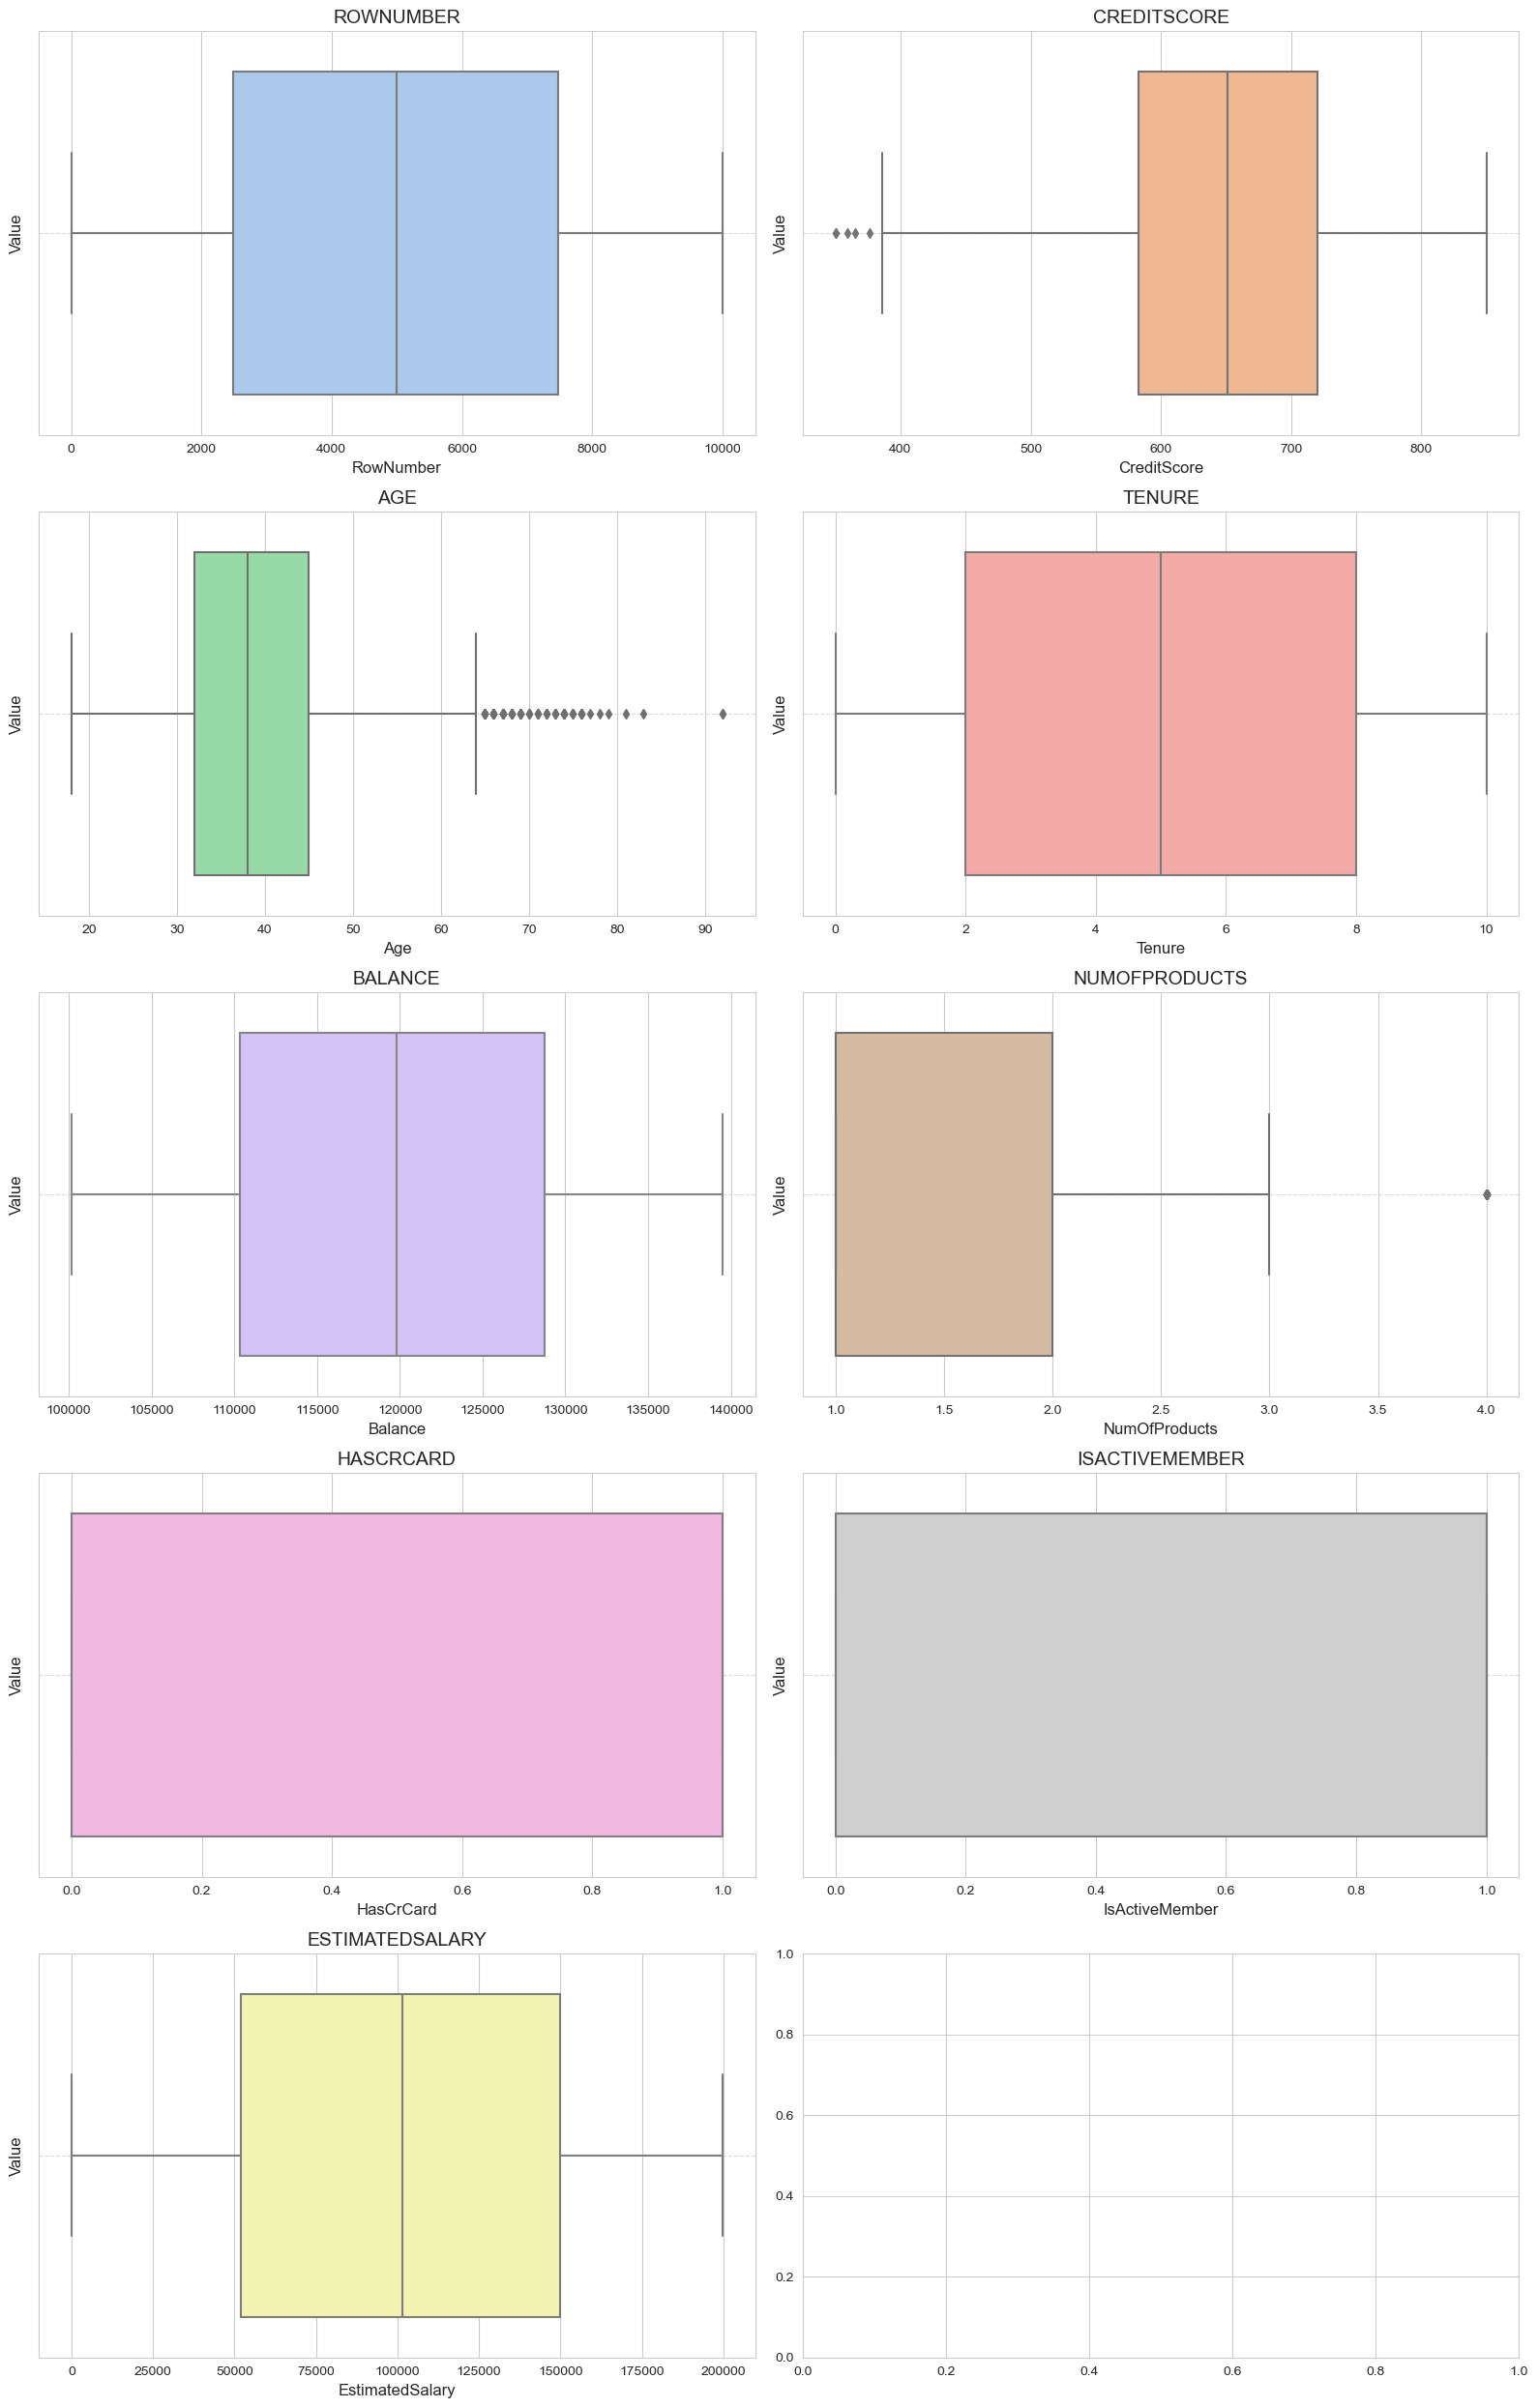

In [17]:
fig, ax = plt.subplots(math.ceil(len(numerical_columns)/2),2,figsize=(16, 5 * math.ceil(len(numerical_columns) / 2)))
box_color_palette = sns.color_palette("pastel")

for i, col in enumerate(numerical_columns):
    sns.boxplot(data=X_clean, x=col, color = box_color_palette[i%len(box_color_palette)], ax = ax.flatten()[i])
    ax.flatten()[i].set_title(str(col).upper(),fontsize=14)
    ax.flatten()[i].set_xlabel(col, fontsize=12)
    ax.flatten()[i].set_ylabel('Value', fontsize=12)
    ax.flatten()[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [18]:
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder',OneHotEncoder(handle_unknown='ignore'))
])

In [19]:
preprocessor = ColumnTransformer(transformers = [
    ('num',numeric_transformer,numerical_columns),
    ('cat',categorical_transformer,categorical_columns)
])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [21]:
#  Logistic Regression

lr_cls = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',LogisticRegression())
])

lr_cls.fit(X_train,y_train)
lr_cls.score(X_test,y_test)

0.7830853563038371

In [22]:
# Random Forest
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Train and evaluate Random Forest
rf_clf.fit(X_train, y_train)
rf_clf.score(X_test,y_test)

0.826938136256852

In [23]:
# XGBClassifier
xgb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(max_depth=3))
])

# Train and evaluate Random Forest
rf_clf.fit(X_train, y_train)
rf_clf.score(X_test,y_test)

0.8324197337509789

In [24]:
y_probas = [c.fit(X_train,y_train).predict_proba(X_test) for c in [lr_cls, rf_clf, xgb_clf]]
y_probas

[array([[0.71127059, 0.28872941],
        [0.5029789 , 0.4970211 ],
        [0.84364706, 0.15635294],
        ...,
        [0.69903315, 0.30096685],
        [0.54549506, 0.45450494],
        [0.73828943, 0.26171057]]),
 array([[0.97, 0.03],
        [0.3 , 0.7 ],
        [0.86, 0.14],
        ...,
        [0.68, 0.32],
        [0.46, 0.54],
        [0.83, 0.17]]),
 array([[0.94050217, 0.05949781],
        [0.17350626, 0.82649374],
        [0.89697975, 0.10302024],
        ...,
        [0.743171  , 0.256829  ],
        [0.7148565 , 0.28514352],
        [0.937473  , 0.06252702]], dtype=float32)]

In [25]:
# probabilities for logictic regression

y_probas_log = y_probas[0][:,1]

# probabilities for logictic regression

y_probas_ran_for = y_probas[1][:,1]

# probabilities for logictic regression

y_probas_xgb = y_probas[1][:,1]


In [32]:
roc_auc_scores = []
for probas in y_probas:
    roc_auc = roc_auc_score(y_test, probas[:,1])
    roc_auc_scores.append(roc_auc)

In [33]:
for i,auc in enumerate(roc_auc_scores):
    print(f'Classifier {i+1} auc score : {auc} ')

Classifier 1 auc score : 0.7572316061654184 
Classifier 2 auc score : 0.8189630276369253 
Classifier 3 auc score : 0.8313543100842875 
